In [1]:
import pandas as pd
import numpy as np
with open('text8') as f:
    text = f.readline().split(' ')
steps = int(len(text)/30)
sentences = [text[30*index:30*(index+1)] for index in np.arange(steps)]
for i in range(len(sentences)):
    sentence = [word.lower() for word in sentences[i] if len(word)>0 and word.lower() not in ['a', 'an', 'the', 'is', 'am', 'was', 'are', 'and', 'or', 'of', 'for', 'he', 'she', 'i']]
    sentences[i] = sentence

In [2]:
from tqdm import tqdm
import tensorflow.compat.v1 as tf
class app2vec:
    def __init__(self, sentences,  embedding_size, word2index=None, index2word=None, vocab_size=None,
                 vocab=None, K=10, window_size=5, learning_rate=0.01, random_seed=79, distortion = 0.75,
                 batch_size=64, is_weighted=False, sentences_gap_time=None, alpha=0.8, epislon=1e-3,
                 use_log_distribution = True, min_word_count=5, epochs=10):
        """
        app2vec的tensorflow实现
        :param sentences: 训练语料（即app序列）
        :param vocab_size: 字典大小
        :param embedding_size: 嵌入矩阵的维度
        :param word2index: 词到索引的转换字典
        :param index2word: 索引到词的转换字典
        :param vocab: 字典，如果use_log_distribution为真，则索引从小到大按照词频从大到小排列
        :param K: 负采样的采样数量
        :param window_size: 生成训练样本时的窗口大小（生成的训练样本长度为[batch_size, 2 * window_size]）
        :param learning_rate: 反向传播学习率
        :param random_seed: 随机种子
        :param distortion: 用于对均匀分布进行扭曲，word2vec原论文中使用distortion=0.75来做扭曲使得词频大的样本
        采样的频率不会过大，词频小的样本采样的频率不会过小
        :param batch_size:训练时的batch_size大小
        :param is_weighted:是否使用安装时间加权
        :param sentences_gap_time:与sentences规格一样，每一个app的安装时间
        :param alpha:
        :param epislon:如果加权，每一个词的最小权重，防止loss爆炸，出现nan的情况
        :param use_log_distribution:是否使用log分布抽样，如果是则vocab排序必须有序，如果否则默认
        使用原word2vec中调整的均匀分布进行采样。
        :param min_word_count: 进入词典的最小出现频次数，如果低于此数值则默认设置为unknown
        :param epochs: 初始化训练次数
        """
        if (is_weighted == True) and (sentences_gap_time is None):
            raise Exception('加权条件下必须给出对应的gap_time值！')
 
        self.random_seed = random_seed
        if vocab_size and word2index and index2word and vocab:
            self.vocab_size = vocab_size
            self.word2index = word2index
            self.index2word = index2word
            self.vocab = vocab
        else:
            self.vocab, self.word2index, self.index2word, self.vocab_size = self._get_vocab_size_and_word_index(sentences, min_word_count)

        self.embedding_size = embedding_size
        self.window_size = window_size
        self.get_vector = None
        self.batch_size = batch_size
        self.unigrams = list(self.vocab.values())

        self.distortion = 0.75
        self.K = K
        self.learning_rate = learning_rate
        self.epislon = epislon
        # self.word_vector 规格为[None, window_size, embedding_size]
        self.is_weighted = is_weighted
        self.sentences_gap_time = sentences_gap_time
        self.alpha = alpha
        self.use_log_distribution = use_log_distribution
        self.distortion = distortion
 
        self.sentences = self.preprocess(sentences)
        self.word_weight=None
        if self.is_weighted:
            self.word_vector, self.word_weight, self.label = self.transform_sentences()
        else:
            self.word_vector, self.label = self.transform_sentences()
        self.wordVectors = None
        print(f'训练集大小为{self.word_vector.shape[0]}')
        self._init_graph()
        print(f'开始训练*******************************')
        total_loss = self.fit(self.word_vector, self.label, self.word_weight, epochs=epochs)
 
    def __len__(self):
        return len(self.vocab)

    def _get_vocab_size_and_word_index(self, sentences, min_word_count):
        trans_sentences = []
        index2word = dict()
        vocab = dict()
        for sentence in sentences:
            for word in sentence:
                try:
                    vocab[word]+=1
                except:
                    vocab[word]=1
        vocab_trans = dict()
        for key in vocab.keys():
            if vocab[key] < min_word_count:
                try:
                    vocab_trans['unknown'] += vocab[key]
                except:
                    vocab_trans['unknown'] = vocab[key]
            else:
                vocab_trans[key]=vocab[key]
        vocab_trans['pad']=1
        sorted_words = sorted(vocab_trans, key=lambda r: vocab[r], reverse=True)
        word2index = dict(zip(sorted_words, range(len(sorted_words))))
        index2word = dict(zip(range(len(sorted_words)), sorted_words))
        vocab_size = len(sorted_words)
        return vocab_trans, word2index, index2word, vocab_size

 
    def _get_vector_count(self):
        return self.word_vector.shape[0]
 
    def _init_graph(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            tf.set_random_seed(self.random_seed)
 
            self.weights = self._initialize_weights()
 
            self.context = tf.placeholder(tf.int64, shape=[None, None], name='context')
            self.output = tf.placeholder(tf.int64, shape=[None, 1], name='output')
 
            self.context_v_vector = tf.nn.embedding_lookup(self.weights['embedding_v'], self.context,
                                                           name='context_v_vector')  # [None, window_size, embedding_size]
            self.output_u_vector = tf.nn.embedding_lookup(self.weights['embedding_u'], self.output,
                                                          name='output_u_vector')
            if self.is_weighted:
                self.context_weight = tf.placeholder(tf.float32, shape=[None, None, 1], name='context_weight')
                self.context_weight_norm = tf.div(self.context_weight,
                                                  tf.reduce_sum(self.context_weight, keepdims=True, axis=1),
                                                  name='context_weight_norm')
 
                self.weighted_context_v_vector = tf.multiply(self.context_v_vector, self.context_weight_norm,
                                                             name='weighted_context_v_vector')
                self.context_v_vector_average = tf.reduce_mean(self.weighted_context_v_vector, axis=1,
                                                               name='context_v_vector_average')
 
            else:
                self.context_v_vector_average = tf.reduce_mean(self.context_v_vector, axis=1,
                                                               name='context_v_vector_average')  # [None, embedding_size]
            # self.log_likelyhood_denominator = tf.reduce_sum(tf.exp(tf.matmul(self.context_v_vector_average, tf.transpose(self.u, [1, 0]))), name='log_likelyhood_denominator') # [None]
            # self.log_likelyhood_numerator = tf.diag_part(tf.matmul(self.output_u_vector, tf.transpose(self.context_v_vector_average, [1,0])), name='log_likelyhood_numerator') # [None]
            # self.log_likelyhood = tf.reduce_sum(tf.log(self.log_likelyhood_denominator) - tf.log(self.log_likelyhood_denominator), name='log_likelyhood')
            nce_biases = tf.Variable(tf.zeros([len(self)]))
            if not self.use_log_distribution:
                sample_values = candidate_sampling_ops.fixed_unigram_candidate_sampler(
                    true_classes=self.output,
                    num_true=1,
                    num_sampled=self.K,
                    unique=True,
                    range_max=len(self),
                    seed=self.random_seed,
                    distortion=self.distortion,
                    unigrams=self.unigrams
                )
            else:
                sample_values = None
 
            self.loss = tf.reduce_mean(
                tf.nn.nce_loss(
                    weights=self.weights['embedding_u'],
                    biases=nce_biases,
                    labels=self.output,
                    inputs=self.context_v_vector_average,
                    num_sampled=self.K,
                    num_classes=len(self),
                    sampled_values=sample_values
                )
            )
 
            self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
 
            init = tf.global_variables_initializer()
            self.sess = self._init_session()
            self.sess.run(init)
 
    def _init_session(self):
        config = tf.ConfigProto(device_count={"gpu": 0})
        config.gpu_options.allow_growth = True
        return tf.Session(config=config)
 
    def get_batch(self, word_vector, label, word_weight=None):
        steps = int(word_vector.shape[0] / self.batch_size) + 1
        for i in range(steps):
            try:
                word_batch = word_vector[i * self.batch_size:(i + 1) * self.batch_size, :]
                label_batch = label[i * self.batch_size:(i + 1) * self.batch_size, :]
                if self.is_weighted:
                    weight_batch = word_weight[i * self.batch_size:(i + 1) * self.batch_size, :]
 
            except:
                word_batch = word_vector[i * self.batch_size:, :]
                label_batch = label[i * self.batch_size:, :]
                if self.is_weighted:
                    weight_batch = word_weight[i * self.batch_size:, :]
 
            if self.is_weighted:
                yield word_batch, weight_batch, label_batch
            else:
                yield word_batch, label_batch
 
    def fit_on_batch(self, word_batch, label_batch, weight_batch=None):
        if self.is_weighted:
            feed_dict = {
                self.context: word_batch,
                self.output: label_batch,
                self.context_weight: weight_batch
            }
        else:
            feed_dict = {
                self.context: word_batch,
                self.output: label_batch
            }
 
        loss, opt = self.sess.run([self.loss, self.train_op], feed_dict=feed_dict)
        return loss
 
    def shuffle_word_label(self, word_vector, label, word_weight=None):
        index = np.random.permutation(range(word_vector.shape[0]))
        word_vector = word_vector[index, :]
        label = label[index]
        if self.is_weighted:
            word_weight = word_weight[index, :]
            return word_vector, word_weight, label
        else:
            return word_vector, label
 
    def fit(self, word_vector, label, word_weight=None, epochs=10):
        for epoch in range(epochs):
            steps = int(word_vector.shape[0] / self.batch_size) + 1
            total_loss = []
            if self.is_weighted:
                word_vector, word_weight, label = self.shuffle_word_label(word_vector, label, word_weight)
 
                for word_batch, weight_batch, label_batch in tqdm(
                        self.get_batch(word_vector, label, word_weight), total=steps, postfix=f'epoch: {epoch}',
                        leave=False):
                    if len(word_batch) == 0:
                        break
                    loss = self.fit_on_batch(word_batch, label_batch, weight_batch)
                    total_loss.append(loss)
            else:
                word_vector, label = self.shuffle_word_label(word_vector, label)
 
                for word_batch, label_batch in tqdm(self.get_batch(word_vector, label), total=steps,
                                                             postfix=f'epoch: {epoch}', leave=False):
                    loss = self.fit_on_batch(word_batch, label_batch)
                    total_loss.append(loss)
            print(f'epoch: {epoch} loss:{np.mean(total_loss)}')
        self.wordVectors = self.sess.run(self.weights['embedding_u'])
        self.word_norm = np.sqrt(np.square(self.wordVectors).sum(axis=1))
        return total_loss
 
    def preprocess(self, sentences):
        post_sentences = []
        for sentence in sentences:
            if len(sentence) == 0:
                continue
            else:
                new_sentence = [word if (word in self.word2index.keys()) else 'unknown' for word in sentence]
                post_sentences.append(new_sentence)
        return post_sentences
 
    def transform_sentences(self):
        word_vector = []
        word_weight = []
        labels = []
        if self.is_weighted:
            for sentence, gap_time in tqdm(zip(self.sentences, self.sentences_gap_time),
                                                    total=len(self.sentences)):
                if isinstance(sentence, list):
                    sentence = ['pad'] * self.window_size + sentence + ['pad'] * self.window_size
                    if self.is_weighted:
                        gap_time = [0] * self.window_size + gap_time + [0] * self.window_size
                    for word_index in range(self.window_size, len(sentence) - self.window_size):
                        window = [sentence[word_index + i] for i in range(-self.window_size, self.window_size + 1) if
                                  i != 0]
                        vector = [self.word2index[word] for word in window]
                        
                        vector_window = [gap_time[word_index + i] for i in
                                         range(-self.window_size, self.window_size + 1) if i != 0]
                        label_time = float(gap_time[word_index])
                        vector_weights = [self.epislon if vector_gap == 0 else max(self.epislon, self.alpha ** (
                                    abs(float(vector_gap) - label_time) / 8640000)) for vector_gap in vector_window]
     
                        label = self.word2index[sentence[word_index]]
                        if len(vector_weights) == len(vector):
                            word_weight.append(vector_weights)
                            word_vector.append(vector)
                        else:
                            print('权重和向量长度不相等！')
                        labels.append(label)
        
            return np.array(word_vector), np.expand_dims(np.array(word_weight), axis=2), np.array(labels).reshape(
                (-1, 1))
        else:
            for sentence in tqdm(self.sentences, total=len(self.sentences)):
                if isinstance(sentence, list):
                    sentence = ['pad'] * self.window_size + sentence + ['pad'] * self.window_size
                    for word_index in range(self.window_size, len(sentence) - self.window_size):
                        window = [sentence[word_index + i] for i in range(-self.window_size, self.window_size + 1) if
                                  i != 0]
                        vector = [self.word2index[word] for word in window]
                        label = self.word2index[sentence[word_index]]
                        word_vector.append(vector)
                        labels.append(label)
            return np.array(word_vector), np.array(labels).reshape((-1, 1))
 
    def _initialize_weights(self):
        weights = dict()
 
        # embeddings
        weights['embedding_u'] = tf.Variable(
            tf.random_normal([self.vocab_size, self.embedding_size], 0.0, 0.01),
            name='embedding_u'
        )
 
        weights['embedding_v'] = tf.Variable(
            tf.random_normal([self.vocab_size, self.embedding_size], 0.0, 0.01),
            name='embedding_v'
        )
        return weights
 
    def get_weight(self, app):
        if isinstance(app, str):
            app = np.array([self.word2index[app]]).reshape((-1, 1))
        else:
            app = np.array([app]).reshape((-1, 1))
        app_weights = self.sess.run(self.output_u_vector, feed_dict={self.output: app})
        return app_weights
 
    def get_most_similar(self, word=None, k=10):
        word_index = self.word2index[word]
        word_vector = self.wordVectors[word_index, :]
        app_norm = np.sqrt(np.square(word_vector).sum())
 
        cos_similarity = np.dot(self.wordVectors, word_vector) / (self.word_norm * app_norm)
        most_k = np.argsort(cos_similarity)[-k:]
        most_similar_word = [self.index2word[i] for i in most_k]
        return most_similar_word

In [58]:
App2Vec = app2vec(sentences[:50000], 30)

100%|█████████████████████████████████████████████████████████████████████████| 50000/50000 [00:03<00:00, 12828.51it/s]


训练集大小为1222362
开始训练*******************************


  0%|                                                                    | 18/19100 [00:00<01:47, 176.94it/s, epoch: 1]

epoch: 0 loss:19.457204818725586


  0%|                                                                    | 21/19100 [00:00<01:33, 204.42it/s, epoch: 2]

epoch: 1 loss:11.265423774719238


  0%|                                                                    | 21/19100 [00:00<01:33, 203.55it/s, epoch: 3]

epoch: 2 loss:10.57028865814209


  0%|                                                                    | 18/19100 [00:00<01:46, 178.70it/s, epoch: 4]

epoch: 3 loss:10.206185340881348


  0%|                                                                    | 20/19100 [00:00<01:38, 192.82it/s, epoch: 5]

epoch: 4 loss:9.980178833007812


  0%|                                                                    | 18/19100 [00:00<01:51, 171.89it/s, epoch: 6]

epoch: 5 loss:9.872269630432129


  0%|                                                                    | 18/19100 [00:00<01:49, 173.53it/s, epoch: 7]

epoch: 6 loss:9.665048599243164


  0%|                                                                    | 19/19100 [00:00<01:43, 184.96it/s, epoch: 8]

epoch: 7 loss:9.649993896484375


  0%|                                                                    | 18/19100 [00:00<01:51, 171.88it/s, epoch: 9]

epoch: 8 loss:9.532127380371094


epoch: 9 loss:9.397991180419922


In [59]:
App2Vec.get_most_similar('first')

['again',
 'last',
 'eighth',
 'third',
 'beating',
 'second',
 'ivo',
 'subsequently',
 'fourth',
 'first']

In [60]:
App2Vec.get_most_similar('red')

['wells',
 'rainbow',
 'disaster',
 'green',
 'pink',
 'brazilian',
 'black',
 'white',
 'yellow',
 'red']

In [3]:
sentences_gap_time = []

for sentence in sentences:
    gap_time = [1606352522]*len(sentence)
    sentences_gap_time.append(gap_time)

In [4]:
App2Vec_time = app2vec(sentences[:50000], 30, sentences_gap_time=sentences_gap_time[:50000], is_weighted=True)

100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:11<00:00, 4327.43it/s]


训练集大小为1222362
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 0]

开始训练*******************************


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 1]

epoch: 0 loss:20.632997512817383


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 2]

epoch: 1 loss:11.667088508605957


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 3]

epoch: 2 loss:11.358113288879395


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 4]

epoch: 3 loss:11.186979293823242


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 5]

epoch: 4 loss:10.996045112609863


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 6]

epoch: 5 loss:10.876816749572754


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 7]

epoch: 6 loss:10.586947441101074


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 8]

epoch: 7 loss:10.557825088500977


  0%|                                                                              | 0/19100 [00:00<?, ?it/s, epoch: 9]

epoch: 8 loss:10.389039039611816


epoch: 9 loss:10.218778610229492


In [5]:
App2Vec_time.get_most_similar('first')

['patented',
 'time',
 'introduced',
 'title',
 'last',
 'fourth',
 'second',
 'third',
 'originally',
 'first']

In [6]:
App2Vec_time.get_most_similar('red')

['player',
 'car',
 'african',
 'indian',
 'rye',
 'bradford',
 'cross',
 'white',
 'black',
 'red']

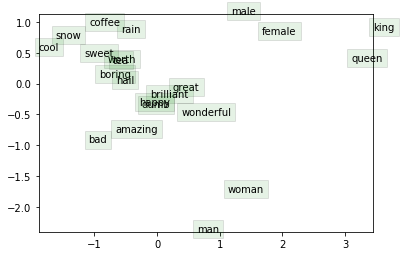

In [30]:
import matplotlib.pyplot as plt
visualizeWords = [
    "great", "cool", "brilliant", "wonderful",  "amazing",
    "worth", "sweet", "boring", "bad", "dumb", "happy", 
     "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]

visualizeIdx = [App2Vec_time.word2index[word] for word in visualizeWords]
visualizeVecs = App2Vec_time.wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2])

for i in range(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i],
        bbox=dict(facecolor='green', alpha=0.1))

plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

plt.savefig('word_vectors.png')